# 🚨 Cybersecurity Anomaly Detection Workflow

This notebook outlines a comprehensive workflow for detecting suspicious activities within logs using advanced machine learning techniques applied to the BETH dataset.

The dataset, as discussed in the article [<<article_name>>], serves as the foundation for preprocessing and performance comparison.

## 📚 Libraries

- Utilizing essential data science, machine learning, and natural language processing packages for a robust analysis.
- Downloading the punkt tokenization module to enhance natural language processing capabilities.


In [1]:
import ast
import re
from pathlib import Path
import matplotlib.pyplot as plt
import mlflow
import nltk
import numpy as np
import pandas as pd
import seaborn as sns


In [2]:
def read_data() -> set[pd.DataFrame]:
    """
    Read in the data from the csv files.
    Args:
        None

    Returns:
        train_df (pd.DataFrame): The training data.
        val_df (pd.DataFrame): The validation data.
        test_df (pd.DataFrame): The testing data.
    """
    train_df = pd.read_csv("data/labelled_training_data.csv")
    val_df = pd.read_csv("data/labelled_validation_data.csv")
    test_df = pd.read_csv("data/labelled_testing_data.csv")
    return train_df, val_df, test_df

## 📊 Exploratory Data Analysis (EDA)

Commencing the analysis by opening and consolidating all data files.

The objectives are two-fold:
1. Gain an intuitive understanding of the dataset.
2. Validate the consistency across the train-validation-test datasets, ensuring minimal discrepancies.


In [3]:
train_df, val_df, test_df = read_data()
train_df["source"] = "Train set"
val_df["source"] = "Validation set"
test_df["source"] = "Test set"
combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
combined_df.head()

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil,source
0,1809.495787,381,7337,1,100,4026532231,close,ip-10-100-1-120,157,prctl,"[140662171848350, 11649800180280676]",5,0,"[{'name': 'option', 'type': 'int', 'value': 'P...",1,0,Train set
1,1809.495832,381,7337,1,100,4026532231,close,ip-10-100-1-120,3,close,[140662171777451],1,0,"[{'name': 'fd', 'type': 'int', 'value': 19}]",1,0,Train set
2,1809.495921,381,7337,1,100,4026532231,close,ip-10-100-1-120,1010,sched_process_exit,[],0,0,[],1,0,Train set
3,1894.139651,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,21,access,[],2,-2,"[{'name': 'pathname', 'type': 'const char*', '...",1,0,Train set
4,1894.142127,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,1005,security_file_open,"[139778263990104, 139778263906698]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",1,0,Train set


In [21]:
def plot_by_source(x: str, kind: str) -> None:
    """
    Plots a frequency distribution by data source.
    Hue (color) by "source" column.
    Args:
        x (str): The column to plot.
        kind (str): The type of plot to generate.
            Options: "hist", "kde", "ecdf"

    Returns:
        None
    """
    plot = sns.displot(combined_df, x=x, kind=kind, hue="source")
    plot.set(
        title=f"{x} Frequency by data source",
        xlabel=x,
        ylabel="Frequency",
    )
    plt.savefig(f"plots/{x}.png")

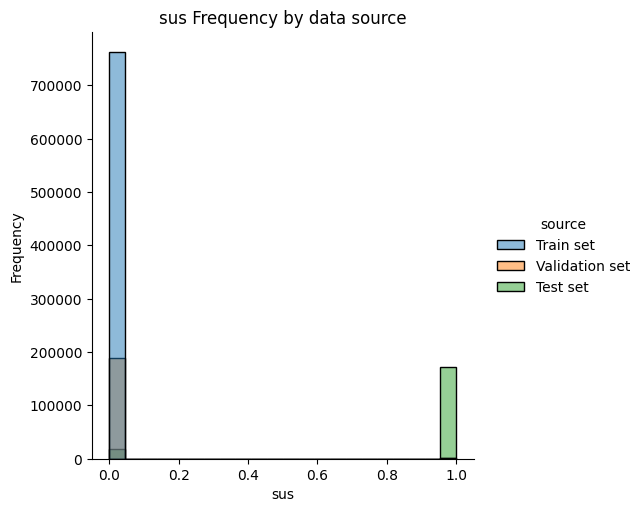

In [22]:
plot_by_source(
    x="sus",
    kind="hist",
)

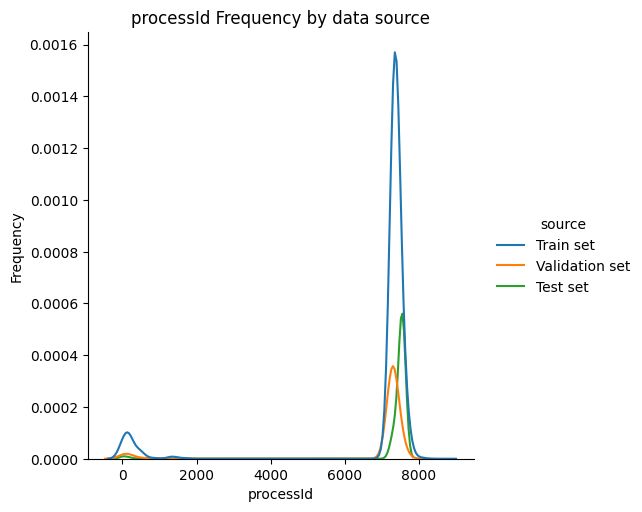

In [23]:
plot_by_source(
    x="processId",
    kind="kde",
)

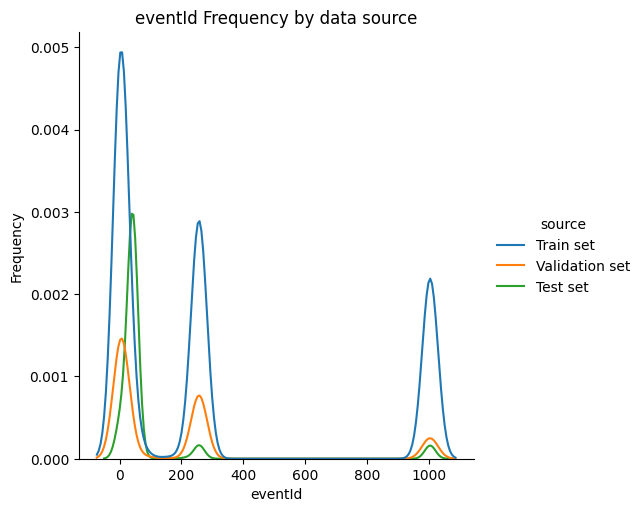

In [24]:
plot_by_source(
    x="eventId",
    kind="kde",
)

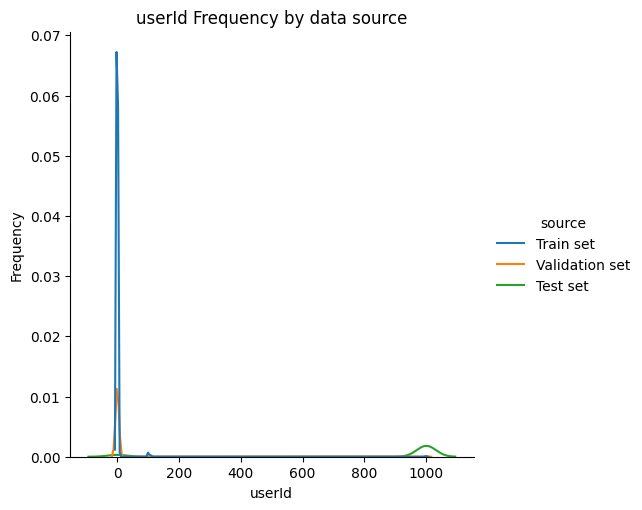

In [25]:
plot_by_source(
    x="userId",
    kind="kde",
)

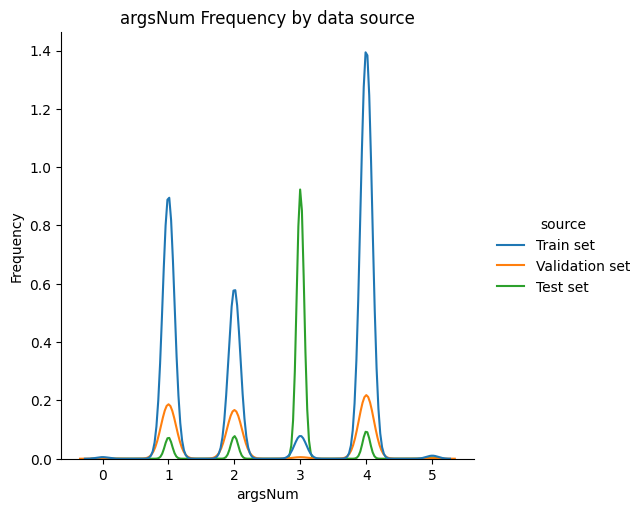

In [26]:
plot_by_source(
    x="argsNum",
    kind="kde",
)

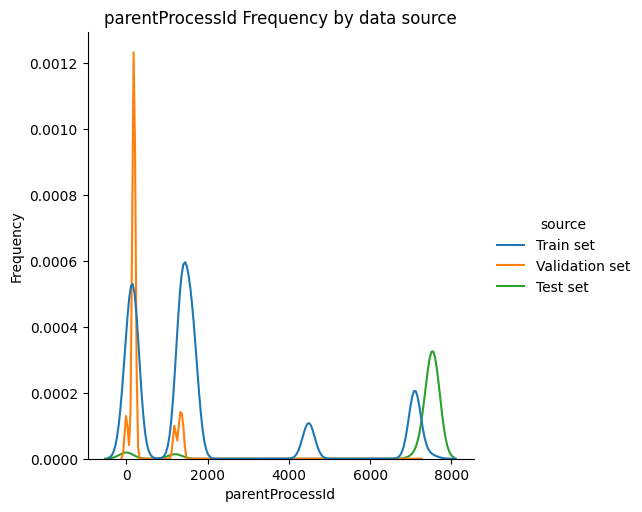

In [27]:
plot_by_source(
    x="parentProcessId",
    kind="kde",
)

In [28]:
combined_df.describe().T

,count,mean,std,min,25%,50%,75%,max
timestamp,1141078.0,1.367449e+03,1154.433376,1.244392e+02,4.612974e+02,9.033516e+02,2.327305e+03,3.954588e+03
processId,1141078.0,6.909070e+03,1816.699147,1.000000e+00,7.301000e+03,7.366000e+03,7.461000e+03,8.619000e+03
threadId,1141078.0,6.913038e+03,1807.393062,1.000000e+00,7.301000e+03,7.366000e+03,7.461000e+03,8.619000e+03
parentProcessId,1141078.0,2.467229e+03,2862.639715,0.000000e+00,1.870000e+02,1.385000e+03,4.489000e+03,7.672000e+03
userId,1141078.0,1.437311e+02,350.094691,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.001000e+03
mountNamespace,1141078.0,4.026532e+09,172.669668,4.026532e+09,4.026532e+09,4.026532e+09,4.026532e+09,4.026532e+09
eventId,1141078.0,2.372977e+02,354.831933,2.000000e+00,4.000000e+00,4.200000e+01,2.570000e+02,1.010000e+03
argsNum,1141078.0,2.671557e+00,1.250393,0.000000e+00,1.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00
returnValue,1141078.0,3.018248e+00,322.346826,-1.150000e+02,0.000000e+00,0.000000e+00,0.000000e+00,3.276800e+04
sus,1141078.0,1.520615e-01,0.359081,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [17]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1141078 entries, 0 to 1141077
Data columns (total 17 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   timestamp        1141078 non-null  float64
 1   processId        1141078 non-null  int64  
 2   threadId         1141078 non-null  int64  
 3   parentProcessId  1141078 non-null  int64  
 4   userId           1141078 non-null  int64  
 5   mountNamespace   1141078 non-null  int64  
 6   processName      1141078 non-null  object 
 7   hostName         1141078 non-null  object 
 8   eventId          1141078 non-null  int64  
 9   eventName        1141078 non-null  object 
 10  stackAddresses   1141078 non-null  object 
 11  argsNum          1141078 non-null  int64  
 12  returnValue      1141078 non-null  int64  
 13  args             1141078 non-null  object 
 14  sus              1141078 non-null  int64  
 15  evil             1141078 non-null  int64  
 16  source           1

In [18]:
combined_df.isna().sum()

timestamp          0
processId          0
threadId           0
parentProcessId    0
userId             0
mountNamespace     0
processName        0
hostName           0
eventId            0
eventName          0
stackAddresses     0
argsNum            0
returnValue        0
args               0
sus                0
evil               0
source             0
dtype: int64

In [19]:
a = test_df["sus"] == test_df["evil"]
print("Accuracy of sus == evil in test set:\n", sum(a) / len(a) * 100)

Accuracy of sus == evil in test set:
 93.10620372869337


In [20]:
numerical_columns = combined_df.select_dtypes(
    include="number"
).columns.tolist()
non_numerical_columns = combined_df.select_dtypes(
    exclude="number"
).columns.tolist()

### Numerical Features

In [ ]:
numerical_columns

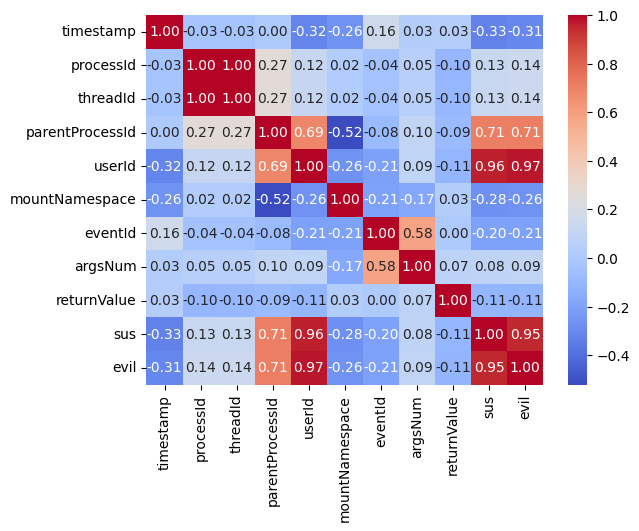

In [29]:
sns.heatmap(
    combined_df.select_dtypes(include="number").corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
)
plt.savefig("heatmap.jpg")
plt.show()

##### ProcessID & ThreadID Clarification
While these features appear identical in their correlations, it's important to note that this similarity is probably a result of the rounding format.

In [ ]:
combined_df[combined_df["processId"] != combined_df["threadId"]][
    ["processId", "threadId"]
]